# Classification with ResNet18 Pre-Trained Model using PyTorch

<h2 id="download_data">Download Data</h2>


In [ ]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

In [ ]:
!unzip -q Positive_tensors.zip

In [ ]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip

In [ ]:
!unzip -q Negative_tensors.zip

In [ ]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [ ]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
from torch.optim import lr_scheduler
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
import torch.nn.functional as F
from matplotlib.pyplot import imshow
from tqdm import tqdm
import copy
torch.manual_seed(0)

In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<h2 id="data_class">Dataset Class</h2>


In [ ]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:1125]
            self.Y=self.Y[0:1125]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[1125:]
            self.Y=self.Y[1125:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        image=torch.load(self.all_files[idx])
        y=self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

print("done")

done


In [ ]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.4MB/s]


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [ ]:
for params in model.parameters():
    params.requires_grad=False

In [ ]:
n_classes = 2
model.fc = nn.Linear(512, n_classes)

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

In [ ]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [ ]:
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

In [ ]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(validation_dataset)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        # Loop through the data in loader

        for x, y in train_loader:
            model.train()

            z = model(x)
            loss = criterion(z, y)
            loss_list.append(loss.data.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("epoch {} done".format(epoch) )

        scheduler.step()
        correct = 0


        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return accuracy_list,loss_list, model

In [ ]:
n_epochs=1
loss_list=[]
accuracy_list=[]
accuracy_list,loss_list, model=train_model(model,train_loader , validation_loader, criterion, optimizer, n_epochs=n_epochs)

The first epoch should take several minutes


  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-23-0db8f6d40b0b>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


epoch 0 done


100%|██████████| 1/1 [05:17<00:00, 317.90s/it]


In [ ]:
print("The Accuracy is: ", max(accuracy_list) * 100)

The Accuracy is:  99.41333333333333


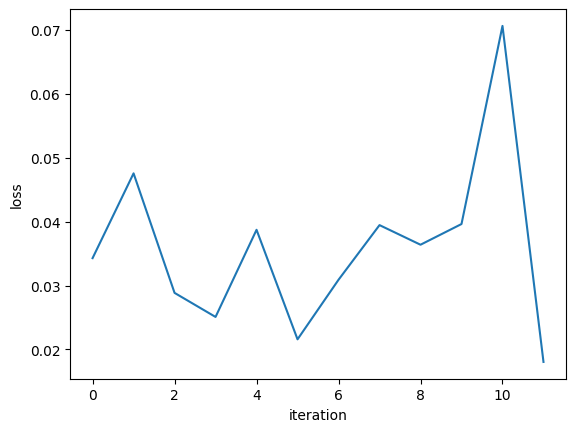

In [ ]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [ ]:
counter = 0
for i,(x,y) in enumerate(validation_dataset):
    z = model(x.reshape(1, 3, 224, 224))
    _, yhat = torch.max(z, 1)
    if yhat !=y:
      print("yhat: ",yhat.item(), "y: ",y.item())
      print("Index of Mis-Classified Samples: ", i)
      counter += 1
    if counter == 4:
      break

<ipython-input-23-0db8f6d40b0b>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx])


yhat:  0 y:  1
Index of Mis-Classified Samples:  77
yhat:  0 y:  1
Index of Mis-Classified Samples:  99
yhat:  0 y:  1
Index of Mis-Classified Samples:  399
yhat:  0 y:  1
Index of Mis-Classified Samples:  471
